# Description
In this notebook will be showed all functionalits that does all the processing: 
* windowing - performs windowing operation so that there is better contrast between soft and hard tissue
* shuffling - shuffles input data
* resizing - resize to preffered dimensions
* saving - save images to output directory
* converting images to one side unifomrly (left or right).

Also, this class can be used as a part of the pipeline, to preprocess all input images and loads them to memory.

Note: dataset can be found on link: https://www.kaggle.com/competitions/rsna-breast-cancer-detection/data
<br>or by running a comamand: kaggle competitions download -c rsna-breast-cancer-detection



In [1]:
# Install required libraries
!pip install -qU python-gdcm pydicom pylibjpeg
!pip install -qU dicomsdl



### Imports

In [2]:
import os
import time
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import pydicom
import dicomsdl
from pydicom.pixel_data_handlers import apply_windowing

from enum import Enum
import matplotlib.pyplot as plt

### Defining helper classes

In [3]:
class BoundingBox(object):
    def __init__(self, top_left, bottom_right):
        self.top_left = top_left
        self.bottom_right = bottom_right

In [4]:
class Side(Enum):
    LEFT = 1
    RIGHT = 2

### Main class preprocessor
Note: it has only one public method, and all others are private, but since the purpose of this notebook is to provide demo on the class functionality, those functions will be converted to public.

In [5]:
class Preprocessor(object):
    """Class that preprocess input dataset in dicom format for breast cancer recognition. 
    """
    def __init__(self, imgs_path: str, csv_path: str):
        """
        Args:
            imgs_path (str): Path to images
            csv_path (str): Path to csv metadata
        """
        self.imgs_path = imgs_path
        self.csv_path = csv_path

    def process_images(self, n, windowing = True, shuffle = False, size = (512, 512), to_dtype = 'uint8', save = False, 
                 returnProcessedImgs = False, convertToOneSide = False, side = Side.LEFT):

        """ Main function that does all the processing: windowing, shuffling, resizing, saving and converting images to one side unifomrly (left or right)
        Args:
            n (int): Number of images to process
            windowing (bool): Windowing technique to be applied. Defaults to True.
            shuffle (bool): Weather images will be shuffled. Defaults to False.
            size (tuple): output image size. Defaults to (512, 512)
            to_dtype (string): Output image format. Defaults to 'uint8'.
            save (bool): Weather images will be saved. Defaults to False.
            returnProcessedImgs (bool): Weather images will be return as function result. Can be used when directly preprocessing for training in pipeline. Defaults to False.
            convertToOneSide (bool): Weather images will be converted to one side, either left or right. Defaults to False.
            side (Side): Which side (left or right) are images oriented.
        Returns:
            List: List of processed images.
        """
        paths = self.get_file_paths(self.imgs_path, self.csv_path, n, shuffle = shuffle)
        retVal = []
        
        for i, path in enumerate(paths):
            img = self.get_pixels(path, windowing = windowing, to_dtype = to_dtype)
            # determine side before cropping
            img_side = self.determine_side(img)

            bbox, _ = self.get_bbox(img, 5)
            img = self.crop_image(img, bbox)
            
            if convertToOneSide:
                # if image is not on specified side
                if img_side != side: 
                    # Use Flip code 1 to flip horisontally
                    img = cv2.flip(img, 1)
                
                
            img = cv2.resize(img, size)
            if save:
                orig_img_name = path.split(sep = '/')[-1]
                img_name = orig_img_name.split(sep = '.')[0] + '.png'
                cv2.imwrite(os.path.join('/kaggle/working/' , img_name), img)
                
            if returnProcessedImgs:
                retVal.append(img)
        
        
        return retVal
        
        
            
    def get_file_paths(self, imgs_path: str, csv_path: str, n: int, shuffle = False):
        """_summary_

        Args:
            imgs_path (str): path to directory contatining images
            csv_path (str): path to directory contatining csv data
            n (int): number of images to load
            shuffle (bool): Weather images will be shuffled. Defaults to False.

        Returns:
            List: list of paths to file
        """
        
        df = pd.read_csv(csv_path)
        if shuffle:
            data = np.random.permutation(df[['image_id', 'patient_id']].values)
            img_id = data[:, 0]
            patient_id = data[:, 1]
        else:
            data = df[['image_id', 'patient_id']].values
            img_id = data[:, 0]
            patient_id = data[:, 1]    
        file_names = []
        for i in range(n):
            file_names.append(f'{imgs_path}/{str(patient_id[i])}/{str(img_id[i])}.dcm')

        return file_names
    
    
    def get_pixels(self, dcm_file : str, windowing = True, to_dtype = 'uint8'):
        """  Gets image as numpy array in specified datatype from dicom format

        Args:
            dcm_file (str): Path to dcm file
            windowing (bool): Windowing technique to be applied.. Defaults to True.
            to_dtype (string): Output image format. Defaults to 'uint8'.

        Raises:
            Exception: For invalid arguments

        Returns:
            np.array: Image
        """
        valid_dtype = ['float16', 'float32','uint8']
        if to_dtype not in valid_dtype:
            raise Exception(f"{to_dtype} is not valid argument. Valid arguments are {valid_dtype}")

        scan = pydicom.dcmread(dcm_file)

        data = scan.pixel_array

        # apply windowing to the original image to make contrast between soft and
        # hard tissue more visible
        if windowing:
            data = apply_windowing(data, scan)

        # normalize image to 
        if scan.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        else:
            data = data - np.min(data)

        if np.max(data) != 0:
            data = data / np.max(data)

        if to_dtype == 'uint8':
            data=(data * 255).astype(dtype = to_dtype)
        else:
            data=data.astype(dtype = to_dtype)


        return data
    
    
    def get_bbox(self, img, threshold = 5):
        """
        img: input image
        threashold: should be 5, experimentally derived
        """
        if img.dtype == 'uint8':
            ret, thresh = cv2.threshold(img, threshold, 255, 0)
        else:
            img = (255*img).astype(dtype = 'uint8')
            ret, thresh = cv2.threshold(img, threshold, 255, 0)

        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = max(contours, key=cv2.contourArea)

        contour = np.squeeze(contour)
        bbox = BoundingBox(top_left = (min(contour[:, 0]), min(contour[:, 1])), bottom_right = (max(contour[:, 0]), max(contour[:, 1])))
        return bbox, img # return bbox and image in uint8 representation
    

    def determine_side(self, img, threshold = 5):
        """
        img: input image
        threshold: for binirizing image, should be 5
        Side is determined simply by finding more white side of the image.
        """

        if img.dtype == 'uint8':
            ret, thresh = cv2.threshold(img, threshold, 255, 0)
        else:
            img = (255*img).astype(dtype = 'uint8')
            ret, thresh = cv2.threshold(img, threshold, 255, 0)

        width = img.shape[1]
        # take all columns up to half image (in width), sumarize them and compare with other half
        if sum(sum(thresh[:, :width // 2])) > sum(sum(thresh[:, width // 2:])): 
            return Side.LEFT
        else:
            return Side.RIGHT
    
    
    def crop_image(self, img, bbox):
        """
        img: image to crop
        bbox: bounding box that defines new image
        """
        return img[bbox.top_left[1]:bbox.bottom_right[1], bbox.top_left[0]:bbox.bottom_right[0]]

# Preprocessor demo

Side.LEFT
Side.LEFT
Side.RIGHT
Side.RIGHT
Side.LEFT


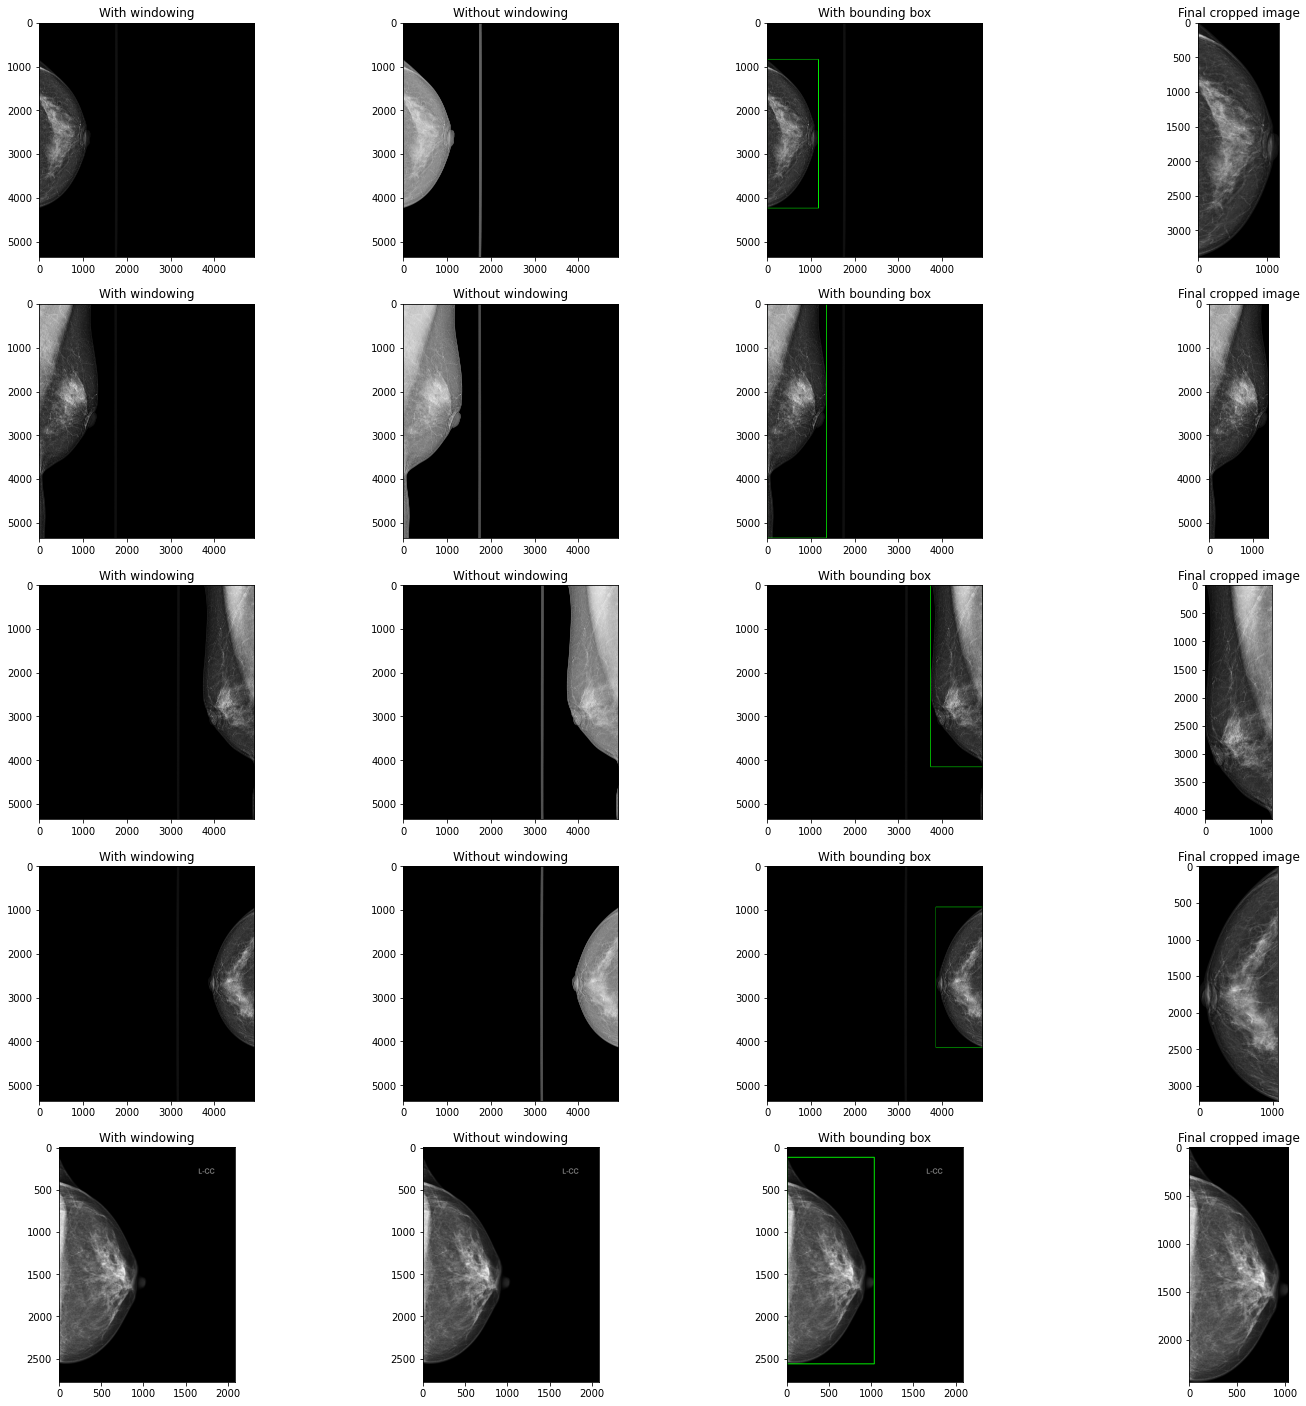

In [6]:

csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
imgs_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'

preprocessor = Preprocessor(imgs_path, csv_path)
paths = preprocessor.get_file_paths(imgs_path, csv_path, n = 5, shuffle = False)

f, ax = plt.subplots(5, 4, figsize = (25, 25))
imgs = []
for i, path in enumerate(paths):
    img_windowed = preprocessor.get_pixels(path, windowing = True, to_dtype = 'uint8')
    plt.subplot(5, 4, 4*i + 1)
    plt.title('With windowing')
    plt.imshow(img_windowed, cmap = 'gray')
    
    img = preprocessor.get_pixels(path, windowing = False, to_dtype = 'uint8')
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(img, cmap = 'gray')
    plt.title('Without windowing')
    
    
    bbox, img = preprocessor.get_bbox(img_windowed, 5)
    # convert to colored and plot bounding box
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    # plot bounding box with green
    boxed_img = cv2.rectangle(img, bbox.top_left, bbox.bottom_right, (0, 255, 0), 10)
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(boxed_img)
    plt.title('With bounding box')
    
    
    final_img = preprocessor.crop_image(img_windowed, bbox)
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(final_img, cmap = 'gray')
    plt.title('Final cropped image')
    
    side = preprocessor.determine_side(img_windowed)
    print(side)

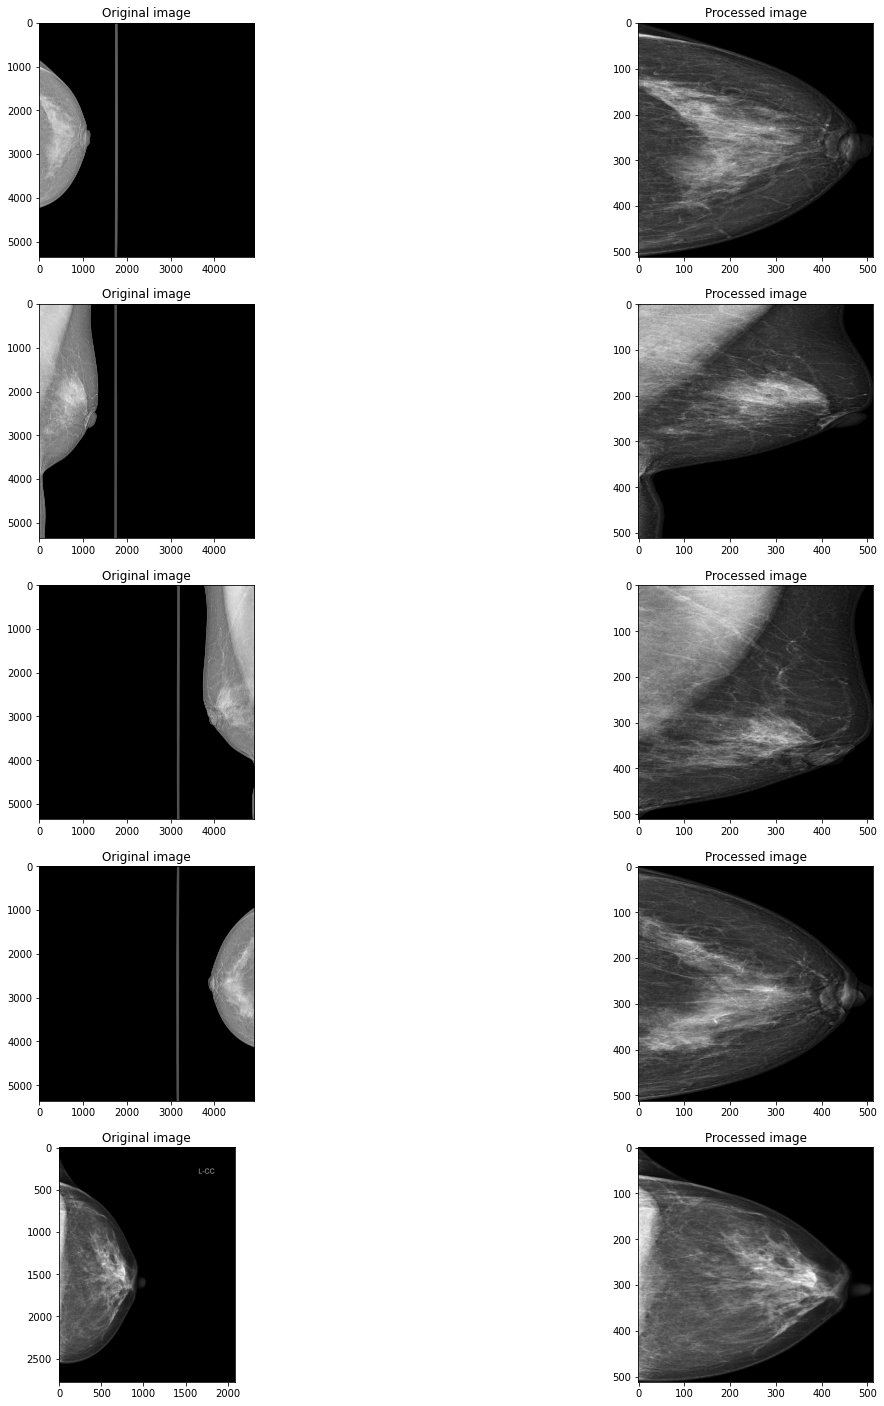

In [7]:
csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
imgs_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'

preprocessor = Preprocessor(imgs_path, csv_path)
paths = preprocessor.get_file_paths(imgs_path, csv_path, n = 5)

original_imgs = []
for path in paths:
    original_imgs.append(preprocessor.get_pixels(path, windowing = False))

imgs = preprocessor.process_images(n = 5, windowing = True, shuffle = False, size = (512, 512), to_dtype = 'uint8', save = True, 
                 returnProcessedImgs = True, convertToOneSide = True, side = Side.LEFT)

f, ax = plt.subplots(5, 2, figsize = (20, 25))
for i, img in enumerate(imgs):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(original_imgs[i], cmap = 'gray')
    plt.title('Original image')
    
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(img, cmap = 'gray')
    plt.title('Processed image')

    